### We will be using pytorch datasets and data loaders to implement u-net residual model 

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F  # useful stateless functions
import numpy as np

from utils import *

from torchvision import transforms, datasets

import logging

In [26]:
root_dir = '/Users/abharani/Documents/myworkspace/cs231n_project'
data_dir =  '/Users/abharani/Documents/myworkspace/cs231n_project/data/output'



csv_path = os.path.join(data_dir,'train.csv')
small_csv_path = os.path.join(data_dir,'small_train.csv')
tiny_csv_path = os.path.join(data_dir,'tiny_train.csv')
dir_checkpoint = os.path.join(root_dir, 'checkpoints')

In [27]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [28]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder(os.path.join(data_dir,'output'), transform=Compose([Resize((224,224)),ToTensor(), 
                                                                      Normalize(mean=[0.485, 0.456, 0.406],
                                                                               std=[0.229, 0.224, 0.225]) 
                                                                      ]))
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x],32, shuffle=True, num_workers=4) for x in ['train','val']}
train_loader = dataloaders['train']
val_loader = dataloaders['val']

x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/abharani/Documents/myworkspace/cs231n_project/data/output/output'

In [29]:
x,y = next(iter(dataloaders['train']))
y

tensor([2, 0, 4, 4, 1, 1, 5, 4, 3, 0, 4, 1, 5, 0, 0, 1, 5, 4, 0, 4, 1, 0, 5, 3, 4, 3, 4, 1, 5, 4, 5, 3])

In [30]:
dataset_sizes = {
    x: len(datasets[x]) for x in datasets.keys()
}

AttributeError: module 'torchvision.datasets' has no attribute 'keys'

In [31]:
# def load_data(root_path, batch_size, phase):
#     transform_dict = {
#         'train': transforms.Compose(
#         [transforms.RandomResizedCrop(224),
#          transforms.RandomHorizontalFlip(),
#          transforms.ToTensor(),
#          transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                               std=[0.229, 0.224, 0.225]),
#          ]),
#         'valid': transforms.Compose(
#         [transforms.Resize(224),
#          transforms.ToTensor(),
#          transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                               std=[0.229, 0.224, 0.225]),
#          ])}
#     data = datasets.ImageFolder(root=root_path, transform=transform_dict[phase])
#     print(len(data))
#     data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)
#     return data_loader 

In [37]:
from torchvision import transforms, datasets, models
from torchvision import models

base_model = models.resnet18(pretrained=False)
    
list(base_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [52]:
import torch
import torch.nn as nn

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)

        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        # MY experiment
        self.fc = nn.Linear(301056, 6)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        

        # MY experiment
        x = out.view(out.size(0), -1)
        x = self.fc(x)
        
        # x = F.adaptive_avg_pool2d(out, output_size=1)
        # print(x.size(),x)

        
        return x



In [43]:
from collections import defaultdict
import torch.nn.functional as F
import torch
from torch.utils.tensorboard import SummaryWriter


# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)
        
# #     pred = torch.sigmoid(pred)
#     dice = dice_loss(pred, target)
    
#     loss = bce * bce_weight + dice * (1 - bce_weight)
    
#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
#     return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

criterion = nn.CrossEntropyLoss()

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    writer = SummaryWriter(comment="Dummy Run")
    global_step = 0    
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            running_loss = 0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device=device, dtype=torch.long)            

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    scores = model(inputs)
#                     _, outputs = torch.max(scores.data, 1)
                    
                    loss = criterion(scores, labels)

                    writer.add_scalar('Loss/train', loss.item(), epoch)
                    
                    _, pred_label = torch.max(scores, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                running_loss += loss.item() * inputs.size(0) # batch_size 
                running_corrects += torch.sum(pred_label == labels.data)
            global_step += 1
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [44]:
def new_train_model(model, device, epochs=5, batch_size=1, lr=0.001, val_percent=0.1, save_cp=True):

    # dataset = BasicDataset(csv_file=tiny_csv_path, data_dir=data_dir)
    # n_val = int(len(dataset) * val_percent)
    # n_train = len(dataset) - n_val
    # train, val = random_split(dataset, [n_train, n_val])
    # train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    # val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

    # dataloaders = {'train': train_loader, 'val':val_loader}

    # dataset_sizes = {'train':n_train, 'val':n_val}

    # default `log_dir` is "runs" - we'll be more specific here
    writer = SummaryWriter('runs/experiment_1')
    global_step = 0

    # print(f'''Starting training:
    #     Epochs:          {epochs}
    #     Batch size:      {batch_size}
    #     Learning rate:   {lr}
    #     Training size:   {n_train}
    #     Validation size: {n_val}
    #     Checkpoints:     {save_cp}
    #     Device:          {device.type}
    # ''')

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))

        model.train()

        epoch_loss = 0.00 
        epoch_accuracy = 0.00
        running_loss = 0.00
        running_corrects = 0.00 
        for i, batch in enumerate(train_loader) :

            imgs = batch[0].to(device, dtype=torch.float32)
            # imgs = torch.reshape(imgs,(imgs.shape[0],imgs.shape[3],imgs.shape[1],imgs.shape[2])) #  inputs.reshape [N, C, W, H]

            true_label = batch[1].to(device=device, dtype=torch.long)

            logits = model(imgs)
            _, pred_label = torch.max(logits, 1)
            loss = criterion(logits, true_label)

            epoch_loss += loss.item()
            running_loss += loss.item() * imgs.size(0) # batch_size 
            running_corrects += torch.sum(pred_label == true_label.data)

            #tensorboard
            img_grid = torchvision.utils.make_grid(imgs)
            # writer.add_image("training Images grid" , img_grid)
            writer.add_scalar('Training Loss', loss.item(), global_step)

            if i %10 ==0: # print loss every 10th step
                print('Epoch {} , Train Step {}, Training loss: {}'.format(epoch, i , loss.item()))

            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.step()


            global_step += 1
            if global_step % (len(dataset) // (10 * batch_size)) == 0:
                # for tag, value in model.named_parameters():
                #     tag = tag.replace('.', '/')
                #     writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                #     writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                val_score = eval_model(model, val_loader, device)
                scheduler.step()
                print('Validation loss: {}'.format(val_score))

                #tensorboard
                writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)
                writer.add_scalar('Validation Loss', val_score, global_step)
                writer.add_images('images', imgs, global_step)

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        print.info(' epoch {}, Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))
        writer.add_scalar("epoch loss", epoch_loss, epoch)
        writer.add_scalar("epoch acc", epoch_acc, epoch)

        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
                print('Created checkpoint directory')
            except OSError:
                pass
            torch.save(model.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            print(f'Checkpoint {epoch + 1} saved !')
    writer.close()

In [45]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device='cpu'
num_class = 6

model = ResNetUNet(num_class).to(device)

# freeze backbone layers
# Comment out to finetune further
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
        
# model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=1)

# model = new_train_model(model, device, epochs=1, batch_size=1, lr=0.001,val_percent=0.1, save_cp=True)

cpu


In [46]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [47]:
from fastai2.vision.widgets import *
from fastai2.vision.all import *

In [14]:
path = Path(data_dir)

In [49]:
dls = bears.dataloaders(path)

Could not do one pass in your dataloader, there is something wrong in it


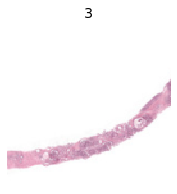

In [16]:
dls.valid.show_batch(max_n=1,nrows=1)

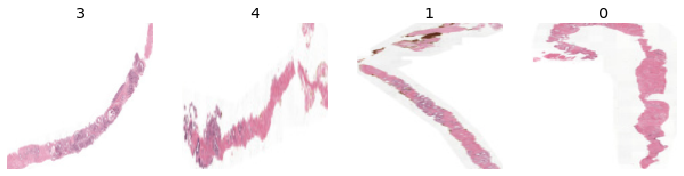

In [19]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3),batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [50]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [51]:
learn = cnn_learner(dls, model, metrics=error_rate)
learn.fine_tune(4)

TypeError: forward() got an unexpected keyword argument 'pretrained'